In this notebook, we run several simple experiments to gain a deeper understanding of the metrics that we use to evaluate our models and how they respond to changes in the parameters we use for generating our in silico data.

In [3]:
# imports
import torch

from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

from yeastdnnexplorer.data_loaders.synthetic_data_loader import SyntheticDataLoader
from yeastdnnexplorer.ml_models.simple_model import SimpleModel

import matplotlib.pyplot as plt

torch.manual_seed(42)  # For CPU
torch.cuda.manual_seed_all(42)  # For all CUDA devices

Define checkpoints and loggers for the models

In [4]:
# define checkpoints for the model
# tells it when to save snapshots of the model during training
# Callback to save the best model based on validation loss
best_model_checkpoint = ModelCheckpoint(
    monitor="val_mse",
    mode="min",
    filename="best-model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

# Callback to save checkpoints every 5 epochs, regardless of performance
periodic_checkpoint = ModelCheckpoint(
    filename="periodic-{epoch:02d}",
    every_n_epochs=2,
    save_top_k=-1,  # Setting -1 saves all checkpoints
)

# configure loggers
tb_logger = TensorBoardLogger("logs/tensorboard_logs")
csv_logger = CSVLogger("logs/csv_logs")

Here we define a helper function that will generate data and train a simple linear model with all of the given parameters, print the test results of the model, and return the trained model and its test results. This will allow us to easily run experiments where we compare model performance while tweaking data or model parameters.

In [5]:
def train_simple_model_with_params(
    batch_size: int,
    lr: float,
    max_epochs: int,
    using_random_seed: bool,
    accelerator: str,
    num_genes: int,
    bound_mean: float,
    val_size: float,
    test_size: float,
    bound: list[float],
    n_sample: list[int],
    max_mean_adjustment: float,
) -> LightningModule:
    data_module = SyntheticDataLoader(
        batch_size=batch_size,
        num_genes=num_genes,
        bound_mean=bound_mean,
        bound=bound,  # old: [0.1, 0.15, 0.2, 0.25, 0.3],
        n_sample=n_sample,  # sum of this is num of tfs
        val_size=val_size,
        test_size=test_size,
        random_state=42,
        max_mean_adjustment=max_mean_adjustment,
    )

    num_tfs = sum(data_module.n_sample)  # sum of all n_sample is the number of TFs

    model = SimpleModel(input_dim=num_tfs, output_dim=num_tfs, lr=lr)
    trainer = Trainer(
        max_epochs=max_epochs,
        deterministic=using_random_seed,
        accelerator=accelerator,
        # callbacks=[best_model_checkpoint, periodic_checkpoint],
        # logger=[tb_logger, csv_logger],
    )
    trainer.fit(model, data_module)
    test_results = trainer.test(model, datamodule=data_module)
    print("Printing test results...")
    print(
        test_results
    )  # this prints all metrics that were logged during the test phase

    return model, test_results

### Experiment 1

Now we can use this function to run simple experiments, like testing how the model's test mse changes when we tweak the mean of the bound genes while holding all other parameters the same. For simplicity, we will not be performing any mean adjustments while generating the data, but we could modify this in the future by incresing the max_mean_adjustment (to use a normal mean adjustment) or adding onto our experiment function to take in our special mean adjustment functions (to use either of the special dependent mean adjustment logic that we've defined, see `generate_in_silico_data.ipynb` for more about this).

Note that this will create a lot of output since we are training several models, so we create the plot in a separate cell.

In [8]:
bound_means = [0.5, 1.0, 2.0, 3.0, 5.0]
test_mses = []
for bound_mean in bound_means:
    model, test_results = train_simple_model_with_params(
        batch_size=32,
        lr=0.01,
        max_epochs=10,
        using_random_seed=True,
        accelerator="cpu",
        num_genes=1000,
        val_size=0.1,
        test_size=0.1,
        bound=[0.5] * 5,
        n_sample=[1, 1, 2, 2, 4],  # sum of this is num of tfs
        bound_mean=bound_mean,
        max_mean_adjustment=0.0
    )
    test_mses.append(test_results[0]["test_mse"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params
----------------------------------------------
0 | mae     | MeanAbsoluteError | 0     
1 | SMSE    | SMSE              | 0     
2 | linear1 | Linear            | 110   
----------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            0.5135628581047058
        test_mse             0.416797935962677
        test_smse           10.241324424743652
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params
----------------------------------------------
0 | mae     | MeanAbsoluteError | 0     
1 | SMSE    | SMSE              | 0     
2 | linear1 | Linear            | 110   
----------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_mse': 0.416797935962677, 'test_mae': 0.5135628581047058, 'test_smse': 10.241324424743652}]


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            0.5821905136108398
        test_mse            0.5283595323562622
        test_smse           10.348736763000488
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params
----------------------------------------------
0 | mae     | MeanAbsoluteError | 0     
1 | SMSE    | SMSE              | 0     
2 | linear1 | Linear            | 110   
----------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_mse': 0.5283595323562622, 'test_mae': 0.5821905136108398, 'test_smse': 10.348736763000488}]


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            0.8307084441184998
        test_mse             1.050934910774231
        test_smse           10.213595390319824
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Printing test results...
[{'test_mse': 1.050934910774231, 'test_mae': 0.8307084441184998, 'test_smse': 10.213595390319824}]



  | Name    | Type              | Params
----------------------------------------------
0 | mae     | MeanAbsoluteError | 0     
1 | SMSE    | SMSE              | 0     
2 | linear1 | Linear            | 110   
----------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            1.1858488321304321
        test_mse             2.014770984649658
        test_smse           10.195466995239258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params
----------------------------------------------
0 | mae     | MeanAbsoluteError | 0     
1 | SMSE    | SMSE              | 0     
2 | linear1 | Linear            | 110   
----------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_mse': 2.014770984649658, 'test_mae': 1.1858488321304321, 'test_smse': 10.195466995239258}]


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae             2.091959238052368
        test_mse              6.157958984375
        test_smse           11.987293243408203
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing test results...
[{'test_mse': 6.157958984375, 'test_mae': 2.091959238052368, 'test_smse': 11.987293243408203}]


Plot Results

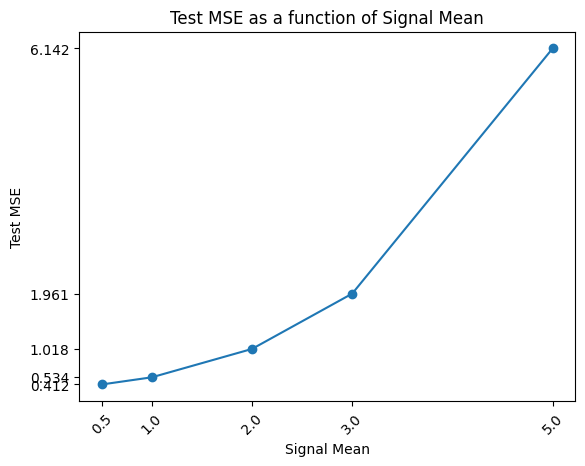

In [7]:
plt.plot(bound_means, test_mses, marker="o")
plt.xlabel("bound Mean")
plt.xticks(bound_means, rotation=45)
plt.yticks(test_mses)
plt.ylabel("Test MSE")
plt.title("Test MSE as a function of bound Mean")
plt.show()

### Experiment 2

We can run a similar experiment where we test the effect of the bound / unbound ratio (aka bound / unbound ratio) on the model's MSE

In [ ]:
bound_unbound_ratios = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9]
test_mses = []

for bound_unbound_ratio in bound_unbound_ratios:
    model, test_results = train_simple_model_with_params(
        batch_size=32,
        lr=0.01,
        max_epochs=10,
        using_random_seed=True,
        accelerator="cpu",
        num_genes=1000,
        val_size=0.1,
        test_size=0.1,
        bound=[bound_unbound_ratio] * 5,
        n_sample=[1, 1, 2, 2, 4],
        bound_mean=3.0,
        max_mean_adjustment=0.0
    )
    print(test_results)
    test_mses.append(test_results[0]["test_mse"])

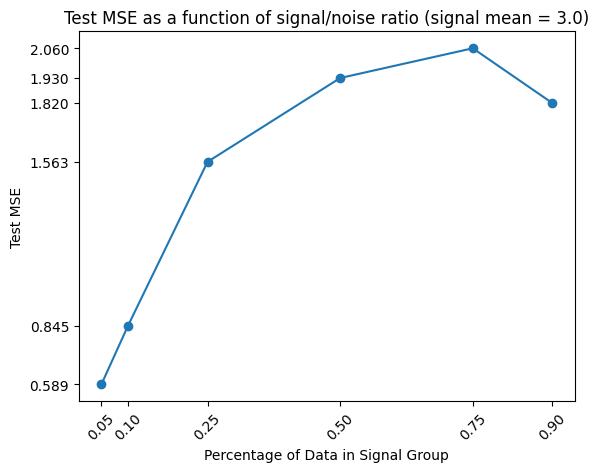

In [7]:
plt.plot(bound_unbound_ratios, test_mses, marker="o")
plt.xlabel("Percentage of Data in bound Group")
plt.ylabel("Test MSE")
plt.xticks(bound_unbound_ratios, rotation=45)
plt.yticks(test_mses)
plt.title("Test MSE as a function of bound/unbound ratio (bound mean = 3.0)")
plt.show()

### Experiment 3

Here we run a little experiment to verify that our smse (standardized mean squared error) metric is actually scale and mean invariant (ie doesn't depend on the scale or mean of the data so long as the variance is roughly the same). Note that this isn't a perfect experiment, as increasing the max mean adjustment (and therefore the scale) will increase the variance by a factor as a result of how our in silico data generation functions work, so there will definitely be a little difference in smse values, but the difference in mse and mae should be a much larger percentage.

We will train and test two models that are exactly the same except that one is trained on a dataset with a small bound mean and mean adjustment and one is trained on a dataset with a large bound mean adn mean adjustment. This will give the two datasets drastically different scales and means. Unfortunately, it will also give them slightly different variances which should cause a slight difference in smse. But again it should be a much smaller percentage difference than the difference between mses and maes

In [ ]:
# these params will be consistent for both datasets
num_genes = 3000
val_size = 0.1
test_size = 0.1
bound = [0.5] * 5
n_sample = [1, 1, 2, 2, 4]
random_state = 42

# the first data loader will load a dataset with a small scale and a small bound mean
small_scale_and_mean_dataloader = SyntheticDataLoader(
    num_genes=num_genes,
    bound=bound, 
    n_sample=n_sample,
    val_size=val_size,
    test_size=test_size,
    random_state=random_state,
    bound_mean=1.0,
    max_mean_adjustment=1.0
)

# the second data loader will generate a dataset with a large scale and a large bound mean
large_scale_and_mean_dataloader = SyntheticDataLoader(
    num_genes=num_genes,
    bound=bound, 
    n_sample=n_sample,
    val_size=val_size,
    test_size=test_size,
    random_state=random_state,
    bound_mean=10.0,
    max_mean_adjustment=10.0
)

num_tfs = sum(n_sample)  # sum of all n_sample is the number of TFs

model = SimpleModel(input_dim=num_tfs, output_dim=num_tfs, lr=0.01)
trainer = Trainer(
    max_epochs=10,
    deterministic=True,
    accelerator='cpu',
    # callbacks=[best_model_checkpoint, periodic_checkpoint],
    # logger=[tb_logger, csv_logger],
)

trainer.fit(model, small_scale_and_mean_dataloader)
small_test_results = trainer.test(model, datamodule=small_scale_and_mean_dataloader)
print("Printing small test results...")
print(small_test_results)


trainer.fit(model, large_scale_and_mean_dataloader)
large_test_results = trainer.test(model, datamodule=large_scale_and_mean_dataloader)
print("Printing large test results...")
print(large_test_results)